Importing

In [5]:
import vizdoom

import numpy as np

import random
import time
import cv2
import gymnasium as gym
import matplotlib.pyplot as plt

Initialize Game

In [5]:
game = vizdoom.DoomGame()
game.load_config(r"vizdoom\scenarios\basic.cfg")
game.init()


Loop through game

In [ ]:
actions = np.eye(3, dtype=np.uint8) # 3 actions: move left, move right, attack

episodes_count = 10
# Loop through the specified number of episodes
for episode in range(episodes_count):
    # Reset the game for a new episode
    game.new_episode()
    # Run while the episode is not finished
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer # Pixels
        info = state.game_variables # Ammo
        reward = game.make_action(random.choice(actions), 4) # 4 ticks per action
        print(f"Episode: {episode}, Reward: {reward}, Info: {info}")
        time.sleep(0.02)  # Slow down the loop for better readability
    print(f"Result: {game.get_total_reward()}")
    time.sleep(2)  # Pause before starting the next episode


Episode: 0, Reward: -4.0, Info: [50.]
Episode: 0, Reward: -9.0, Info: [50.]
Episode: 0, Reward: -4.0, Info: [49.]
Episode: 0, Reward: -4.0, Info: [49.]
Episode: 0, Reward: -9.0, Info: [49.]
Episode: 0, Reward: -4.0, Info: [48.]
Episode: 0, Reward: -4.0, Info: [48.]
Episode: 0, Reward: -4.0, Info: [48.]
Episode: 0, Reward: -4.0, Info: [48.]
Episode: 0, Reward: -9.0, Info: [48.]
Episode: 0, Reward: -4.0, Info: [47.]
Episode: 0, Reward: -4.0, Info: [47.]
Episode: 0, Reward: -4.0, Info: [47.]
Episode: 0, Reward: -4.0, Info: [47.]
Episode: 0, Reward: -9.0, Info: [47.]
Episode: 0, Reward: -4.0, Info: [46.]
Episode: 0, Reward: -4.0, Info: [46.]
Episode: 0, Reward: -4.0, Info: [46.]
Episode: 0, Reward: -9.0, Info: [46.]
Episode: 0, Reward: -4.0, Info: [45.]
Episode: 0, Reward: -4.0, Info: [45.]
Episode: 0, Reward: -4.0, Info: [45.]
Episode: 0, Reward: -4.0, Info: [45.]
Episode: 0, Reward: -4.0, Info: [45.]
Episode: 0, Reward: -9.0, Info: [45.]
Episode: 0, Reward: -4.0, Info: [44.]
Episode: 0, 

In [175]:
class VizDoomEnv(gym.Env):
    def __init__(self, config_path, render=False):
        super().__init__()

        # Setup the Doom game environment
        self.game = vizdoom.DoomGame()
        self.game.load_config(config_path)

        if render:
            self.game.set_window_visible(True)
        else:
            self.game.set_window_visible(False)
        
        self.game.init()

        # Create action space and observation space
        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(104, 160, 1),
            dtype=np.uint8
        )

    def step(self, action):

        actions = np.eye(3, dtype=np.uint8)  # 3 actions: move left, move right, attack
        reward = self.game.make_action(actions[action], 4)  # 4 ticks per action
        terminated = self.game.is_episode_finished()

        state = self.game.get_state()
        if state is not None:
            observation = self.simplify_observation(state.screen_buffer)
            ammo = state.game_variables
            info = {"ammo":ammo}
        else:
            observation = np.zeros(self.observation_space.shape, dtype=np.uint8)
            info = {"ammo":0}

        return observation, reward, terminated, False, info
    
    def reset(self, seed=None):
        self.game.new_episode()
        state = self.game.get_state()
        observation = self.simplify_observation(state.screen_buffer)
        ammo = state.game_variables
        info = {"ammo":ammo}

        return observation, info
    
    def close(self):
        self.game.close()

    def simplify_observation(self, observation):
        # Convert the observation to grayscale and resize it
        gray_observation = cv2.cvtColor(np.moveaxis(observation,0,-1), cv2.COLOR_BGR2GRAY)
        cropped_obervation = gray_observation[:208, :]
        resized_observation = cv2.resize(cropped_obervation, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        simplified_observation = np.expand_dims(resized_observation, axis=-1)  # Add channel dimension
        return simplified_observation



In [127]:
env = VizDoomEnv(r"vizdoom\scenarios\basic.cfg", render=True)

In [149]:
observation = env.step(2)
# np.moveaxis(observation,0,-1)

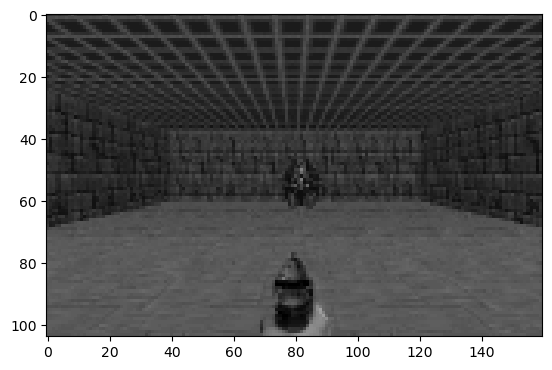

In [155]:
observation = env.reset()[0]
plt.imshow(cv2.cvtColor(observation, cv2.COLOR_BGR2RGB))

In [156]:
env.close()

In [176]:
# Check validity of the environment
from stable_baselines3.common import env_checker
env = VizDoomEnv(r"vizdoom\scenarios\basic.cfg")
env_checker.check_env(env)
env.close()

Callback (saving)

In [177]:
import os
from stable_baselines3.common.callbacks import BaseCallback

In [178]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [179]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [180]:

callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

Train Model

In [181]:
from stable_baselines3 import PPO

In [182]:
# Non rendered environment
env = VizDoomEnv(r"vizdoom\scenarios\basic.cfg")

In [183]:
model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-4, n_steps=2048)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [184]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_basic\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.9     |
|    ep_rew_mean     | -136     |
| time/              |          |
|    fps             | 79       |
|    iterations      | 1        |
|    time_elapsed    | 25       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 25.4         |
|    ep_rew_mean          | -39.4        |
| time/                   |              |
|    fps                  | 65           |
|    iterations           | 2            |
|    time_elapsed         | 62           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0097111575 |
|    clip_fraction        | 0.141        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance 

In [185]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

Test model

In [186]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [188]:
# Reload model from disc
model = PPO.load('./train/train_basic/best_model_100000')

In [189]:
env = VizDoomEnv(r"vizdoom\scenarios\basic.cfg", render=True)

In [190]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)

c:\Users\StevenvdKamp\.conda\envs\VizDoom\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [191]:
mean_reward

np.float64(91.0)

In [196]:
for episode in range(10): 
    obs = env.reset()[0]
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

Total Reward for episode 95.0 is 0
Total Reward for episode 71.0 is 1
Total Reward for episode 87.0 is 2
Total Reward for episode 95.0 is 3
Total Reward for episode 75.0 is 4
Total Reward for episode 95.0 is 5
Total Reward for episode 83.0 is 6
Total Reward for episode 71.0 is 7
Total Reward for episode 75.0 is 8
Total Reward for episode 87.0 is 9


In [197]:
env.close()